In [1]:
# General syntax to import a library but no functions: 
#import (library) as (give the library a nickname/alias)
from pandas import DataFrame, read_csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
matplotlib.style.use('ggplot')

from scipy import stats

# Enable inline plotting
%matplotlib inline

# These are the "Tableau 20" colors as RGB. 

tableau20 = [(31, 119, 180), (255, 127, 14),  
             (44, 160, 44), (214, 39, 40),  
             (148, 103, 189), (140, 86, 75),  
             (227, 119, 194), (127, 127, 127),  
             (188, 189, 34), (23, 190, 207)] 

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  


/Users/ChrisM/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
"""
Create a function that calculates AIM from the output of the log file

This output is generated by Gromacs with AIM in the log file.

  N  CoulL   VdwL    Count   G  dG  dGCoulL  dGVdwL
  1  0.000  0.000    53354    0.00000   -0.10988  72.68642 -39.04117
  2  0.200  0.000    48592   -0.10988    0.03505  49.12180 -10.70077
  3  0.400  0.000    51103   -0.07483    0.02530  30.26744   4.34085
  4  0.600  0.000    53621   -0.04952    0.03545  16.23771  11.27888
  5  0.800  0.000    56754   -0.01408    0.01623   7.06221  13.62888
  6  1.000  0.000    58094    0.00215   -0.00223   0.22630  14.04047
  7  1.000  0.100    57396   -0.00007   -0.04135   0.21780  12.81567
  8  1.000  0.200    54913   -0.04142   -0.02937   0.15792  11.01799
  ...
  

For each log output I extract the output using bash cli:

$tail -135 out01.log | grep -A 24 "MC-lambda" | tr -d '<<'


"""
def get_AIM(file_in, coulLambdas, vdw):
    # import the copied averages from the AIM simu
    location = file_in
    myDeltaG = pd.read_csv(
        location, 
        delim_whitespace=True)

    # only need the average values from the copied info
    dGdcoul = myDeltaG.dGCoulL
    dGdvdw = myDeltaG.dGVdwL

    # we only need the delta lambdas so we don't need a 2d array here
    dlamCoul = np.diff(coulLambdas)
    dlamVdw = np.diff(vdwLambdas)

    # any values that need to be initialized
    myCoulAIM = 0.0
    myVDWAIM = 0.0
    AIMTotal = 0.0

    # loop over to calculate the dvdl totals
    for k in range(len(coulLambdas)-1):
        myCoulAIM += 0.5*np.dot(dlamCoul[k],(dGdcoul[k]+dGdcoul[k+1]))
        myVDWAIM += 0.5*np.dot(dlamVdw[k],(dGdvdw[k]+dGdvdw[k+1]))

    AIMTotal = myCoulAIM + myVDWAIM

    ###############################################################################
    # Is it flat enough?  Is the minimum entry less than 80% of its average value?
    # It is common practice to considr a histogram "sufficiently flat" when its
    # minimum entry is no less than 80% of its average value.
    ###############################################################################

    dfnum = myDeltaG.Count
    flatness = 100*(min(dfnum)/np.average(dfnum))
    if flatness > 80:
        print ("It's flat enough")

    # get the total and print it out
    print myCoulAIM
    print myVDWAIM
    print AIMTotal

    plt.figure
    plt.title("Lambda Histogram", fontsize=22)
    plt.grid(True)
    plt.xlabel("Lambda Values", fontsize=22)
    x = np.linspace(0,1,len(dfnum))
    y = dfnum

    plt.plot(x, y,label="Lambda Histogram");
    plt.bar(x,y, label="Lambda Histogram");

It's flat enough
27.829104
-6.09961725
21.72948675


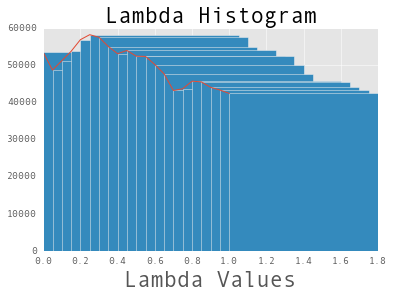

In [3]:
# need the lambda arrays
coulLambdas = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
vdwLambdas = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])

file_in = "aimgpu.log"

get_AIM(file_in, coulLambdas,vdwLambdas)